# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [15]:
import os
import time
import re
import json
import requests
import yaml
from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [16]:
config = {
  **os.environ,
  **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])

In [17]:
gh_limit = github.rate_limit.get()

display(gh_limit['resources']['core'])

```json
{'limit': 5000, 'remaining': 3900, 'reset': 1737800111, 'used': 1100}
```

## Definindo Funções Principais

In [18]:
def get_repo_stars(repo_name):
  name_parts = re.split(r'/', repo_name)
  repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  return repo_details['stargazers_count']


def extract_hpa(yaml_content):
  hpa_list = []
  for doc in yaml_content:
    if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
      hpa_list.append(doc)
  return hpa_list


def download_hpa_spec(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:

    # Remove marcações de template Helm
    clean_text = re.sub(r'{{-.*?}}', '', response.text)
    clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

    yaml_content = list(yaml.safe_load_all(clean_text))
    hpa_content = extract_hpa(yaml_content)
    if hpa_content is None:
      return

    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    
    with open(target_path, 'w') as file:
      file.write(yaml.dump_all(hpa_content))
  else:
    print(f"Loading {url} returned {response.status_code}")

def download_file(url, repo_name, file_path):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')
  
  print(f'Downloading {url}')
  response = requests.get(url)
  if response.status_code == 200:
    target_path = os.path.join("search_results", repo_name, file_path)
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    with open(target_path, 'w') as file:
      file.write(response.text)
  else:
    print(f'Loading {url} returned {response.status_code}')
    

# Realiza a Busca

In [19]:
result_items = []
page = 1

# Carrega a primeira página de itens da pesquisa
search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page, sort='stars')
result_items.extend(search_result['items'])

# Carrega as demais páginas da pesquisa
print(f"Encontrados {search_result['total_count']} itens")
while len(result_items) < search_result['total_count']:
  rate_remaining = github.rate_limit.get()['resources']['code_search']['remaining']
  if rate_remaining <= 1 or search_result['incomplete_results']:
    print(f"Aguardando code_search.remaining {rate_remaining}")
    time.sleep(1)
    continue
  result_items.extend(search_result['items'])
  page += 1
  print(f"Carregando página {page}")
  try:
    search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
  except HTTP422UnprocessableEntityError as e:
    display(e)
    break
  
display(f"Foram carregados {len(result_items)} resultados")

Encontrados 4320 itens
Carregando página 2
Carregando página 3
Carregando página 4
Carregando página 5
Carregando página 6
Carregando página 7
Carregando página 8
Carregando página 9
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando code_search.remaining 1
Aguardando c

<HTTPError 422: 'Unprocessable Entity\n====Error Body====\n{\n  "message": "Cannot access beyond the first 1000 results",\n  "documentation_url": "https://docs.github.com/rest/search/search#search-code",\n  "status": "422"\n}\n'>

'Foram carregados 1100 resultados'

In [20]:
search_items = []
for item in result_items:
  search_items.append({
    'repo_name': item['repository']['full_name'],
    'file_path': item['path'],
    'url': item['html_url'].replace('/blob/', '/raw/')
  })

items = pd.DataFrame(search_items)
display(items)

,repo_name,file_path,url
0,learnk8s/spring-boot-k8s-hpa,kube/hpa.yaml,https://github.com/learnk8s/spring-boot-k8s-hp...
1,krestomatio/keydb-operator,watches.yaml,https://github.com/krestomatio/keydb-operator/...
2,flolu/aspect-typescript,app/app.yaml,https://github.com/flolu/aspect-typescript/raw...
3,anuragbhargava889/kubernetes-demo,api-hpa.yaml,https://github.com/anuragbhargava889/kubernete...
4,chronolaw/k8s_study,ch4/hpa.yml,https://github.com/chronolaw/k8s_study/raw/1ea...
...,...,...,...
1095,rhod3rz/demo1-AzureDevOps-AKS,k8s/titan/individual/votinganalytics/horizonta...,https://github.com/rhod3rz/demo1-AzureDevOps-A...
1096,fortinet/k8s-fortigate-ctrl,examples/voting-app-antiaffinity.yaml,https://github.com/fortinet/k8s-fortigate-ctrl...
1097,ecsimsw/ecsimsw-kube,k8s/hpa/server-album.yaml,https://github.com/ecsimsw/ecsimsw-kube/raw/c5...
1098,icebob/kantab,kubernetes/activities-deployment.yaml,https://github.com/icebob/kantab/raw/12e8ce2c6...


In [21]:
len(items['repo_name'].unique())

866

## Número de Estrelas

In [22]:
repo_names = items['repo_name'].tolist()

star_counts = Parallel(n_jobs=4)(
  delayed(get_repo_stars)(repo_name) for repo_name in repo_names
)

items['repo_stars'] = star_counts

In [23]:
print("Todos os resultados")
display(items['repo_stars'].describe())

min_stars = 1
print(f"Mais do que {min_stars} estrelas")
filter_min_stars = items[items['repo_stars'] > min_stars]
display(filter_min_stars['repo_stars'].describe())

print("Percentil > 0.9 estrelas")
filter_outliers_items = items[items['repo_stars'] >= items['repo_stars'].quantile(0.90)]
display(filter_outliers_items['repo_stars'].describe())


Todos os resultados


count     1100.000000
mean       119.563636
std       1122.209915
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      29406.000000
Name: repo_stars, dtype: float64

Mais do que 1 estrelas


count      292.000000
mean       449.979452
std       2146.387945
min          2.000000
25%          4.000000
50%         13.000000
75%         62.250000
max      29406.000000
Name: repo_stars, dtype: float64

Percentil > 0.9 estrelas


count      111.000000
mean      1170.612613
std       3367.798734
min         30.000000
25%         50.000000
50%        123.000000
75%        381.500000
max      29406.000000
Name: repo_stars, dtype: float64

In [24]:
len(filter_min_stars['repo_name'].unique())

236

Text(0.5, 1.0, 'Histograma Repo Stars > 1')

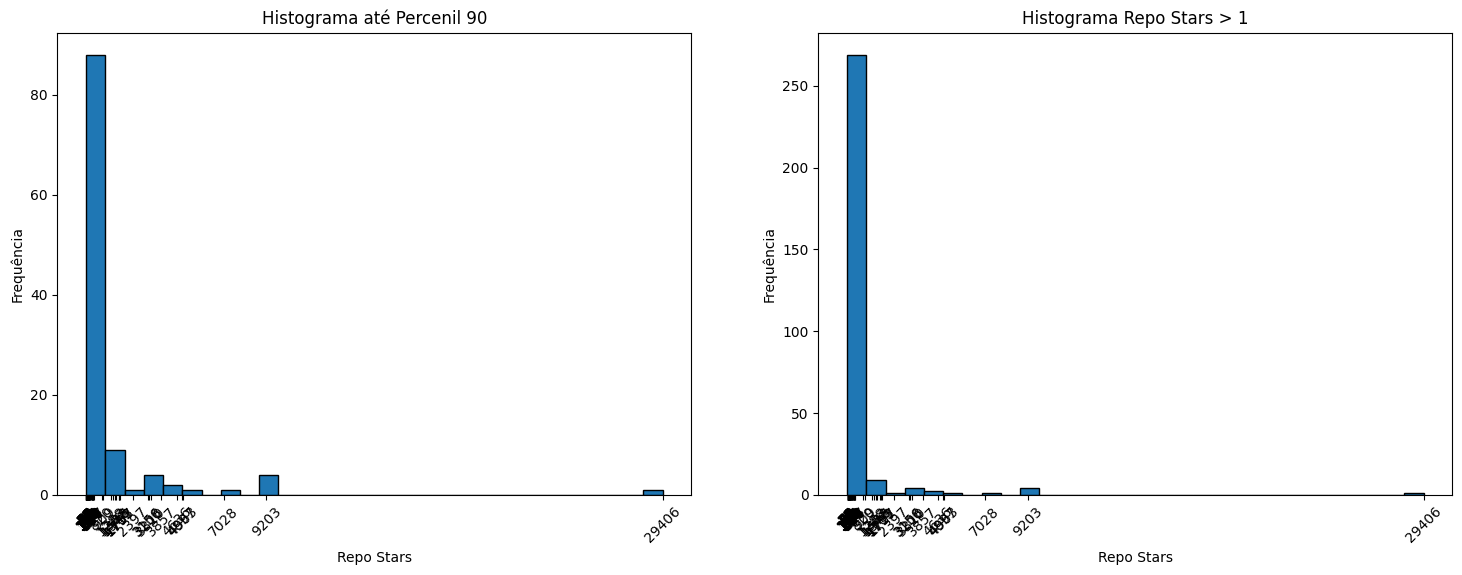

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bins=30
# bins = np.concatenate((np.linspace(0, 50, 20), np.linspace(50, filter_outliers_items['repo_stars'].max(), 10)))

axes[0].hist(filter_outliers_items['repo_stars'], bins=bins, edgecolor='black')
axes[0].set_xlabel("Repo Stars")
axes[0].set_ylabel("Frequência")
axes[0].set_title("Histograma até Percenil 90")
axes[0].set_xticks(filter_outliers_items['repo_stars'].unique())
axes[0].tick_params(axis="x", rotation=45)
axes[1].hist(filter_min_stars['repo_stars'], bins=bins, edgecolor='black')
axes[1].set_xlabel("Repo Stars")
axes[1].set_ylabel("Frequência")
axes[1].set_xticks(filter_outliers_items['repo_stars'].unique())
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title(f"Histograma Repo Stars > {min_stars}")

In [26]:
filtered_items = filter_min_stars.sort_values(by=['repo_stars'])
filtered_items

,repo_name,file_path,url,repo_stars
108,Konstantin-Lanin-it/Mindbox_is_the_best_IT_com...,config.yaml,https://github.com/Konstantin-Lanin-it/Mindbox...,2
107,18F/identity-loadtest,coredns.yaml,https://github.com/18F/identity-loadtest/raw/d...,2
1029,huseyinbabal/spring-boot-argocd,charts/echo-server/templates/hpa.yaml,https://github.com/huseyinbabal/spring-boot-ar...,2
901,Simovative/onPremise-Helm,academyfive/charts/a5Chart/templates/academy-h...,https://github.com/Simovative/onPremise-Helm/r...,2
864,ubc/charts,hotcrp/templates/hpa.yaml,https://github.com/ubc/charts/raw/406ed13d4d4e...,2
...,...,...,...,...
409,bitnami/charts,bitnami/milvus/templates/index-coordinator/hpa...,https://github.com/bitnami/charts/raw/30b43f32...,9203
770,bitnami/charts,bitnami/aspnet-core/templates/hpa.yaml,https://github.com/bitnami/charts/raw/30b43f32...,9203
220,bitnami/charts,bitnami/concourse/templates/worker/horizontalp...,https://github.com/bitnami/charts/raw/30b43f32...,9203
1042,bitnami/charts,bitnami/thanos/templates/query/hpa.yaml,https://github.com/bitnami/charts/raw/30b43f32...,9203


In [27]:
def prepare_csv(item):
  owner_repo = re.split(pattern=r'/', string=item['repo_name'])
  return pd.Series({
    'owner': owner_repo[0],
    'repo': owner_repo[1],
    'path': item['file_path']
  })

csv_prepared = filter_min_stars.apply(prepare_csv, axis=1)
csv_prepared.to_csv('extract.csv')


In [29]:
urls = items['url'].tolist()
repo_names = items['repo_name'].tolist()
file_paths = items['file_path'].tolist()

Parallel(n_jobs=4)(
  delayed(download_file)(url, repo_name, file_path)
  for url, repo_name, file_path in zip(urls, repo_names, file_paths)
)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,